# Data Preparation

In [1]:
# Libraries

# Standard libraries

import numpy as np
import pandas as pd
import kagglehub
import os
pd.set_option('display.max_colwidth', None)  # Show full content of columns

# Visualization libraries 

import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter

# Feature extraction (vectorization)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Stemming and Lemmatization
from nltk.stem.snowball import PorterStemmer
from nltk.stem import WordNetLemmatizer # This one was preferred over PorterStemmer


# Train-test split
from sklearn.model_selection import train_test_split

# Machine learning models

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import imblearn

from imblearn.over_sampling import SMOTE # Addressing class imbalances by increasing minority classes size
from imblearn.under_sampling import RandomUnderSampler # Addressing class imbalances by decreasing majority classes size
from collections import Counter


# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")

# Verify the data is loaded
#display(df.head())

df = df.reset_index(drop=True) # My dataset had null values, but after the splitting some missing values emerged. Potential reason is introduction via test-split due to index misalignmnet.

# The Focus will be between the explanatory variable "cleaned_text" and "Sentiment"

In [4]:
# Features (cleaned text) and target (sentiment)

X = df['cleaned_text']  # Features
y = df['Sentiment']     # Target

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Replace NaN values with an empty string
X_train = X_train.fillna("")
X_test = X_test.fillna("")

# Verify the split proportions
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Sentiment
Positive    0.781249
Negative    0.143840
Neutral     0.074911
Name: proportion, dtype: float64
Sentiment
Positive    0.781248
Negative    0.143840
Neutral     0.074913
Name: proportion, dtype: float64


## From here on, starting with max_features=1000 and evaluate model's performance. If performance drops significantly, increase to 2000 or 3000. Also testing undersampling instead of smote

In [5]:
# TF-IDF vectorizer at 3000 and SMOTE

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))  # Use unigrams and bigrams

# Fit and transform training data, transform test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Check the shape of the transformed data
print(X_train_tfidf.shape, X_test_tfidf.shape)

# Deciding on leaving max_features at 5000 or reducing it down to 1000: 
# Check the distribution of TF-IDF scores: Generate word clouds or analyze the top features with the highest TF-IDF scores at max_features=5000. 
# If the important features are retained in the top 1000, we're likely fine

(451779, 2000) (112945, 2000)


Top features by TF-IDF scores:
        Feature     Score
385        best  0.015517
1558   favorite  0.010487
2593       love  0.010052
4405      taste  0.009985
1620      first  0.009946
1136  delicious  0.009813
3539  recommend  0.009361
424         bit  0.008627
2781        mix  0.008595
978       could  0.008450
2121        hot  0.008117
1648     flavor  0.008086
3162    perfect  0.008027
1432      every  0.007945
2341       keep  0.007928
4268     strong  0.007879
2022    healthy  0.007873
131      always  0.007768
2874       need  0.007742
1427       ever  0.007627


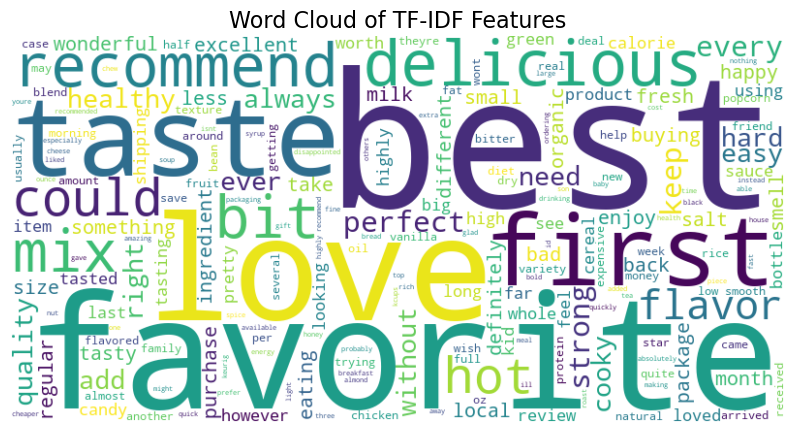

In [8]:
# Get feature names and their corresponding TF-IDF scores
feature_names = tfidf.get_feature_names_out()
tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).flatten()

# Create a DataFrame of features and their scores
tfidf_df = pd.DataFrame({'Feature': feature_names, 'Score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='Score', ascending=False)

# Print the top features for verification
print("Top features by TF-IDF scores:")
print(tfidf_df.head(20))

# Generate a word cloud using the TF-IDF scores
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(tfidf_df['Feature'], tfidf_df['Score']))
)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off the axis
plt.title("Word Cloud of TF-IDF Features", fontsize=16)
plt.show()

# After going back several times to preprocessing and given the rankings, it seems reasonably to use n_max features = 1000 or 2000

## Addressing Class Imbalance via Undersampling (instead of SMOTE)

In [6]:
# Initialize undersampler
undersampler = RandomUnderSampler(random_state=42)

# Apply undersampling
X_train_tfidf_resampled, y_train_resampled = undersampler.fit_resample(X_train_tfidf, y_train)

# Check the new class distribution
print(Counter(y_train_resampled))  # Should show balanced classes

# Compare with the use 
# SMOTE: Counter({'Positive': 355021, 'Negative': 355021, 'Neutral': 355021})
# Undersampler: Counter({'Negative': 33843, 'Neutral': 33843, 'Positive': 33843})

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Counter({'Negative': 33843, 'Neutral': 33843, 'Positive': 33843})


# Modeling: Let's start with heavy models first

## Random Forest

Random Forest Results:
              precision    recall  f1-score   support

    Negative       0.55      0.77      0.64     16246
     Neutral       0.30      0.68      0.41      8461
    Positive       0.96      0.78      0.86     88238

    accuracy                           0.77    112945
   macro avg       0.60      0.74      0.64    112945
weighted avg       0.85      0.77      0.79    112945



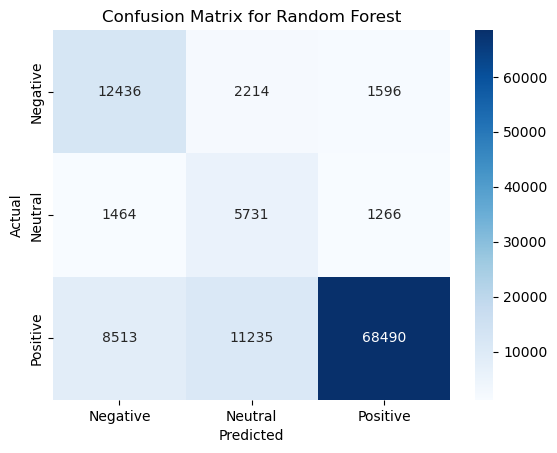

In [11]:
# Random forest: entire sample but 100 estimators

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)

# Classification report
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Only one point gain by doubling the number of threes (50-100) for in precision and recall for the problematic neutral class. I will focus more on postive and negative scores.
# Before optimizing let's run the heavy but arguably better xgboost

## XG Boost

In [ ]:
# Running some checks

# Verify no missing values in the target
print(y_train.isnull().sum(), y_test.isnull().sum())  # Should print 0, 0

# Check class distribution after undersampling
from collections import Counter
print(Counter(y_train_resampled))  # Should show balanced classes

# Verify TF-IDF shapes
print(X_train_tfidf_resampled.shape, X_test_tfidf.shape)

# Verify label mapping
print(y_train_resampled.unique())  # Should be [0, 1, 2]
print(y_test.unique())  # Should be [0, 1, 2]

0 0
Counter({'Negative': 33843, 'Neutral': 33843, 'Positive': 33843})
(101529, 2000) (112945, 2000)
['Negative' 'Neutral' 'Positive']
['Neutral' 'Positive' 'Negative']


In [12]:
# Map string labels to numeric
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y_train_resampled = y_train_resampled.map(label_mapping)
y_test = y_test.map(label_mapping)

print("Mapped values in y_train_resampled:", y_train_resampled.unique())
print("Mapped values in y_test:", y_test.unique())

Mapped values in y_train_resampled: [0 1 2]
Mapped values in y_test: [1 2 0]


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\xgboost\core.py:158: UserWarning: [12:47:01] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

    Negative       0.47      0.55      0.51     16246
     Neutral       0.19      0.52      0.28      8461
    Positive       0.91      0.73      0.81     88238

    accuracy                           0.69    112945
   macro avg       0.53      0.60      0.53    112945
weighted avg       0.80      0.69      0.73    112945



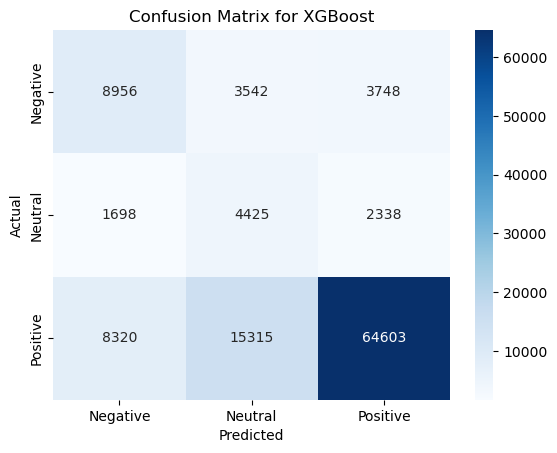

In [14]:
# XG-Boost: 50 trees

# Model
xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Classification report
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix heatmap
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Logistic Regression

Logistic Regression Results (with Resampled Data):
              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60     16246
     Neutral       0.22      0.59      0.31      8461
    Positive       0.96      0.76      0.84     88238

    accuracy                           0.73    112945
   macro avg       0.57      0.67      0.59    112945
weighted avg       0.84      0.73      0.77    112945



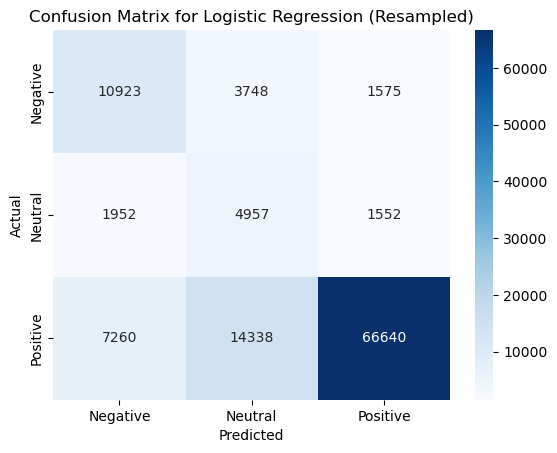

In [15]:
# Train Logistic Regression with resampled data
lr_model_resampled = LogisticRegression(max_iter=1000, random_state=42)
lr_model_resampled.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict on the test set
y_pred_lr = lr_model_resampled.predict(X_test_tfidf)

# Evaluate
print("Logistic Regression Results (with Resampled Data):")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression (Resampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## LightGBM

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346594
[LightGBM] [Info] Number of data points in the train set: 101529, number of used features: 2000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
              precision    recall  f1-score   support

    Negative       0.48      0.57      0.52     16246
     Neutral       0.19      0.53      0.28      8461
    Positive       0.92      0.73      0.82     88238

    accuracy                           0.69    112945
   macro avg       0.53      0.61      0.54    112945
weighted avg       0.80      0.69      0.73    112945



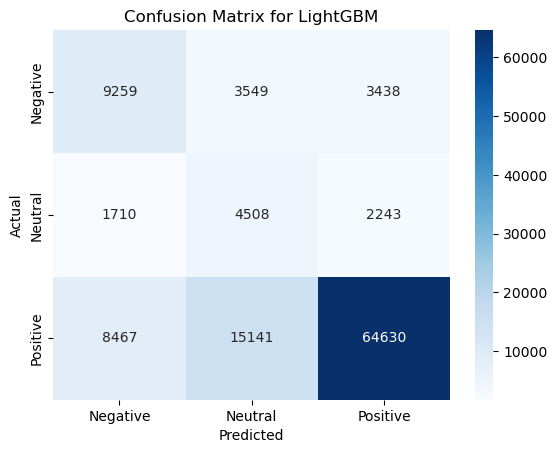

In [16]:
# Ensure input data is in dense format
X_train_tfidf_resampled = X_train_tfidf_resampled.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Step 7: Define the LightGBM model
lgb_model = LGBMClassifier(
    n_estimators=50,    # Number of trees
    max_depth=6,        # Maximum depth of each tree
    learning_rate=0.1,  # Shrinkage step size
    random_state=42,    # For reproducibility
    n_jobs=-1           # Use all CPU cores for training
)

# Step 8: Train the LightGBM model
lgb_model.fit(X_train_tfidf_resampled, y_train_resampled)

# Step 9: Predict on the test set
y_pred_lgb = lgb_model.predict(X_test_tfidf)

# Step 10: Evaluate the model
print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgb, target_names=['Negative', 'Neutral', 'Positive']))

# Step 11: Confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# Step 12: Plot the confusion matrix
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Interpretation: 

I have re-run random forest, XG Boost, logistic regression and Light GBM with max_features of 2000 (tfidf vectorizer) and undersampling instead of SMOTE given the several memory problems I encountered in the last days. There are some differences in results, but not at all dramatic.  

Random Forest consistently performs better compared to the other models, particularly in the recall and F1 scores for the Negative and Positive classes.
Surprisingly, XGBoost underperforms compared to Random Forest and even Logistic Regression. This could be due to the smaller dataset (undersampling instead of SMOTE) and how XGBoost handles such scenarios. XGBoost typically thrives in larger datasets with fine-tuned hyperparameters.
Logistic Regression (your baseline) performs decently but still lags in recall for the Negative and Positive classes.

Negative and Positive reviews are more critical to classify accurately. Neutral reviews, while good for completeness, likely have less impact on actionable insights for businesses.

To summarize:

Reducing max_features to 2000 does not cause dramatic degradation in results. This suggests that your dataset's most informative words are being retained in the top 2000 features.
Undersampling introduces balanced classes and avoids the computational issues encountered with SMOTE, while maintaining reasonable model performance.

Next steps:

Run Grid Search for Random Forest and Logistic Regression:

Random Forest is the top-performing model, so tuning its hyperparameters (e.g., number of estimators, max depth, and minimum samples per split) could yield further improvements.
Keep Logistic Regression as a baseline and run Grid Search to explore slight optimizations (e.g., regularization strength, solver).

Consider Removing Neutral Reviews from the Dataset:
If Neutral reviews are less relevant for your goal, you could filter them out and train your models on just Negative and Positive classes. This could simplify the classification task and potentially improve the performance for those critical classes.

# Modeling Optimization: LR and RF

## Logistic Regression

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best F1-Score: 0.6682634579137351
Logistic Regression Results (after GridSearch):
              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60     16246
     Neutral       0.22      0.58      0.31      8461
    Positive       0.96      0.76      0.84     88238

    accuracy                           0.73    112945
   macro avg       0.57      0.67      0.59    112945
weighted avg       0.84      0.73      0.77    112945



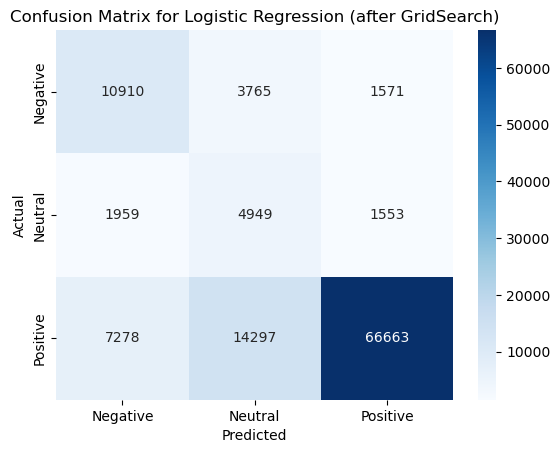

In [19]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Use 'l2' regularization, the most common and robust option
    'solver': ['saga', 'lbfgs'],  # Solvers that work with 'l2' penalty
    'max_iter': [100, 200, 500]  # Number of iterations
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Optimize for F1 macro average
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress during grid search
    n_jobs=-1  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate on test set with the best model
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_tfidf)

# Classification report
print("Logistic Regression Results (after GridSearch):")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Random forest

In [21]:
# Step 1: Define the reduced parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],      # Number of trees
    'max_depth': [10, 20, None],           # Maximum depth of trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]             # Only consider bootstrap sampling
}

# Step 2: Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Step 3: Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='f1_macro',  # Optimize for F1 macro average
    cv=3,                # 3-fold cross-validation
    verbose=1,           # Print progress during grid search
    n_jobs=-1            # Use all available cores
)

# Step 4: Perform grid search
grid_search_rf.fit(X_train_tfidf_resampled, y_train_resampled)

# Step 5: Best parameters and best score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best F1-Score:", grid_search_rf.best_score_)

# Step 6: Evaluate on the test set with the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_tfidf)

# Step 7: Classification report
print("Random Forest Results (after GridSearch):")
print(classification_report(y_test, y_pred_rf, target_names=['Negative', 'Neutral', 'Positive']))

# Step 8: Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Step 9: Plot Confusion Matrix Heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for Random Forest (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Run time 10 mins: 
# The performance is worse than the values delivered by the default values of random forest
# GridSearchCV optimizes the model on cross-validation splits of the training data. However, the splits may not generalize well to unseen data (like the test set).
# The reduced grid search tested a smaller range of hyperparameters, which may have skipped the optimal values for this specific dataset.Random Forests have many hyperparameters, 
# and narrowing the grid to save time can prevent finding the truly optimal combination.


# Default paramters:

#{ 'bootstrap': True,
 #'ccp_alpha': 0.0,
 #'class_weight': None,
 #'criterion': 'gini',
 #'max_depth': None,
 #'max_features': 'sqrt',
 #'max_leaf_nodes': None,
 #'max_samples': None,
 #'min_impurity_decrease': 0.0,
 #'min_samples_leaf': 1,
 #'min_samples_split': 2,
 #'min_weight_fraction_leaf': 0.0,
 #'n_estimators': 100,
 #'n_jobs': None,
 #'oob_score': False,
 #'random_state': None,
 #'verbose': 0,
 #'warm_start': False
#}

# The grid search may have selected a model with deeper trees (e.g., max_depth=10), which might slightly overfit the training data compared to the simpler model.Deeper trees prioritize capturing patterns in the training data, but this can hurt generalization to unseen data

#param_grid_rf = {
 #   'n_estimators': [50, 100],      # Number of trees
  #  'max_depth': [5, 10],           # Maximum depth of trees
   #    'min_samples_split': [2, 5],    # Minimum number of samples required to split an internal node
    #'min_samples_leaf': [1, 2],     # Minimum number of samples required to be at a leaf node
    #'bootstrap': [True]             # Only consider bootstrap sampling

# Let's add more variations

Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 

Why is random forest performing worse after the tuning? 



# Removing the class "Neutral"

In [14]:
# Libraries

# Standard libraries

import numpy as np
import pandas as pd
import kagglehub
import os
pd.set_option('display.max_colwidth', None)  # Show full content of columns

# Visualization libraries 

import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter

# Feature extraction (vectorization)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Stemming and Lemmatization
from nltk.stem.snowball import PorterStemmer
from nltk.stem import WordNetLemmatizer # This one was preferred over PorterStemmer


# Train-test split
from sklearn.model_selection import train_test_split

# Machine learning models

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import imblearn
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE # Addressing class imbalances by increasing minority classes size
from imblearn.under_sampling import RandomUnderSampler # Addressing class imbalances by decreasing majority classes size
from collections import Counter


# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")

# Verify the data is loaded
#display(df.head())

df = df.reset_index(drop=True)

In [3]:
# Step 1: Remove the Neutral Class
df_binary = df[df['Sentiment'] != 'Neutral']  # Remove rows where Sentiment is 'Neutral'

# Verify the new class distribution
print(df_binary['Sentiment'].value_counts())

Sentiment
Positive    441190
Negative     81230
Name: count, dtype: int64


In [4]:
# Step 2: Redefine Features (X) and Target (y)
X_binary = df_binary['cleaned_text']  # Features
y_binary = df_binary['Sentiment']     # Target

# Step 3: Perform Stratified Split
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

# Replace NaN values with an empty string
X_train_binary = X_train_binary.fillna("")
X_test_binary = X_test_binary.fillna("")

# Step 4: TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))  # Use unigrams and bigrams
X_train_tfidf_binary = tfidf.fit_transform(X_train_binary)
X_test_tfidf_binary = tfidf.transform(X_test_binary)

# Step 5: Apply Undersampling 
undersampler = RandomUnderSampler(random_state=42)
X_train_tfidf_resampled_binary, y_train_resampled_binary = undersampler.fit_resample(
    X_train_tfidf_binary, y_train_binary)

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## Logistic Regression

Logistic Regression Results (Binary Classification):
              precision    recall  f1-score   support

    Negative       0.53      0.85      0.65     16246
    Positive       0.97      0.86      0.91     88238

    accuracy                           0.86    104484
   macro avg       0.75      0.86      0.78    104484
weighted avg       0.90      0.86      0.87    104484



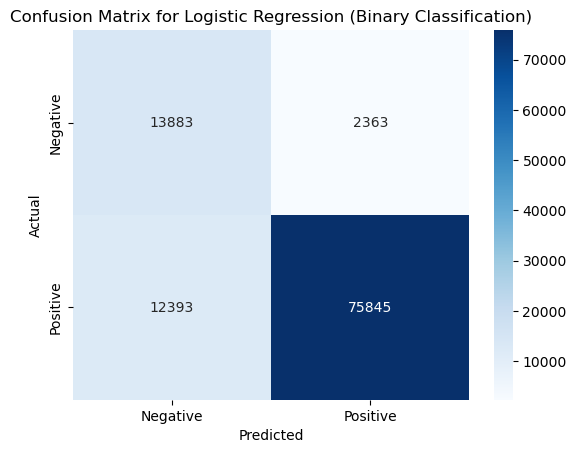

In [16]:
# Step 6: Train Logistic Regression + adding class_weight.

lr_model_binary = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model_binary.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Step 7: Predict on the Test Set
y_pred_lr_binary = lr_model_binary.predict(X_test_tfidf_binary)

# Step 8: Evaluate the Model
print("Logistic Regression Results (Binary Classification):")
print(classification_report(y_test_binary, y_pred_lr_binary, target_names=['Negative', 'Positive']))

# Step 9: Confusion Matrix
cm_lr_binary = confusion_matrix(y_test_binary, y_pred_lr_binary)

# Step 10: Plot Confusion Matrix Heatmap
sns.heatmap(cm_lr_binary, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression (Binary Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1-Score: 0.8578635938238683
Logistic Regression Results (after GridSearch):
              precision    recall  f1-score   support

    Negative       0.53      0.85      0.65     16246
    Positive       0.97      0.86      0.91     88238

    accuracy                           0.86    104484
   macro avg       0.75      0.86      0.78    104484
weighted avg       0.90      0.86      0.87    104484



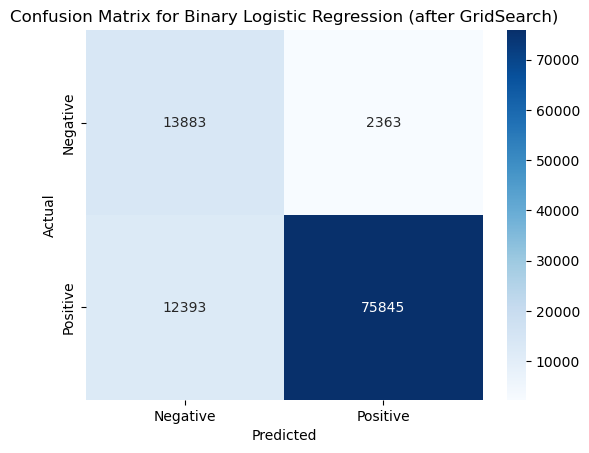

In [7]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Use 'l2' regularization, the most common and robust option
    'solver': ['saga', 'lbfgs'],  # Solvers that work with 'l2' penalty
    'max_iter': [100, 200, 500]  # Number of iterations
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Optimize for F1 macro average
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress during grid search
    n_jobs=-1  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate on test set with the best model
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_tfidf_binary)

# Classification report
print("Logistic Regression Results (after GridSearch):")
print(classification_report(y_test_binary, y_pred_lr_binary, target_names=['Negative', 'Positive']))

# Confusion matrix
cm_lr = confusion_matrix(y_test_binary, y_pred_lr_binary)

# Plot confusion matrix heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Binary Logistic Regression (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Random Forest

Random Forest Results binary classification:
              precision    recall  f1-score   support

           0       0.55      0.89      0.68     16246
           1       0.98      0.87      0.92     88238

    accuracy                           0.87    104484
   macro avg       0.77      0.88      0.80    104484
weighted avg       0.91      0.87      0.88    104484



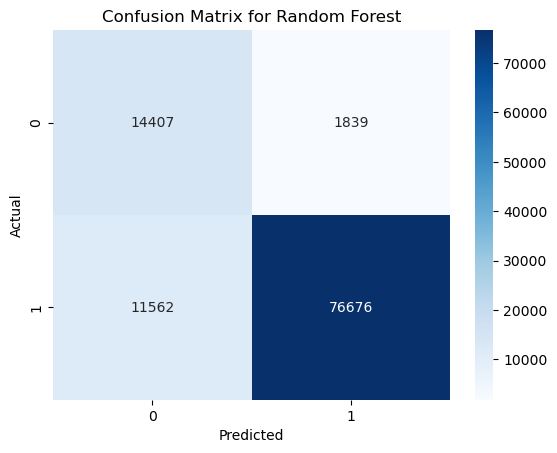

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_tfidf_binary)

# Classification report
print("Random Forest Results binary classification:")
print(classification_report(y_test_binary, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test_binary, y_pred_rf)

# Plot confusion matrix heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best F1-Score: 0.7913252986666145
Random Forest Results Binary (after GridSearch):
              precision    recall  f1-score   support

    Negative       0.50      0.71      0.59     16246
    Positive       0.94      0.87      0.90     88238

    accuracy                           0.84    104484
   macro avg       0.72      0.79      0.75    104484
weighted avg       0.87      0.84      0.85    104484



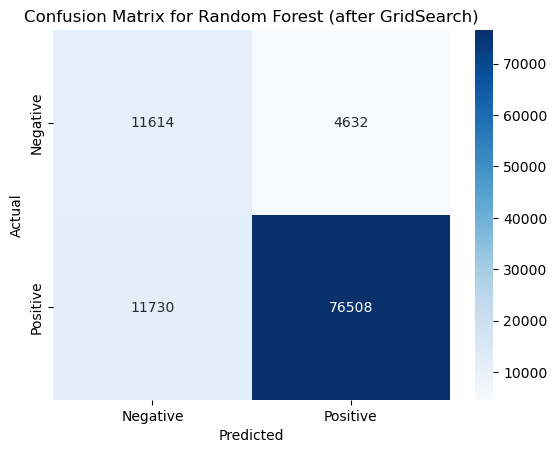

In [10]:
# Step 1: Define the reduced parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],      # Number of trees
    'max_depth': [10, 15, 20],      # Maximum depth of trees
    'min_samples_split': [5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]             # Only consider bootstrap sampling
}

# Step 2: Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Step 3: Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='f1_macro',  # Optimize for F1 macro average
    cv=3,                # 3-fold cross-validation
    verbose=1,           # Print progress during grid search
    n_jobs=-1            # Use all available cores
)

# Step 4: Perform grid search
grid_search_rf.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Step 5: Best parameters and best score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best F1-Score:", grid_search_rf.best_score_)

# Step 6: Evaluate on the test set with the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_tfidf_binary)

# Step 7: Classification report
print("Random Forest Results Binary (after GridSearch):")
print(classification_report(y_test_binary, y_pred_rf, target_names=['Negative', 'Positive']))

# Step 8: Confusion Matrix
cm_rf = confusion_matrix(y_test_binary, y_pred_rf)

# Step 9: Plot Confusion Matrix Heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Random Forest (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Interpreation: Best results are random forrest classifier with default hyperparameters

## XGBoost

In [5]:
# Map string labels to numeric
label_mapping = {'Negative': 0, 'Positive': 1}
y_train_resampled_binary = y_train_resampled_binary.map(label_mapping)
y_test_binary = y_test_binary.map(label_mapping)

print("Mapped values in y_train_resampled:", y_train_resampled_binary.unique())
print("Mapped values in y_test:", y_test_binary.unique())


Mapped values in y_train_resampled: [0 1]
Mapped values in y_test: [1 0]


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\xgboost\core.py:158: UserWarning: [09:51:52] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "scikit_learn", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

    Negative       0.48      0.68      0.56     16246
    Positive       0.94      0.86      0.90     88238

    accuracy                           0.84    104484
   macro avg       0.71      0.77      0.73    104484
weighted avg       0.87      0.84      0.85    104484



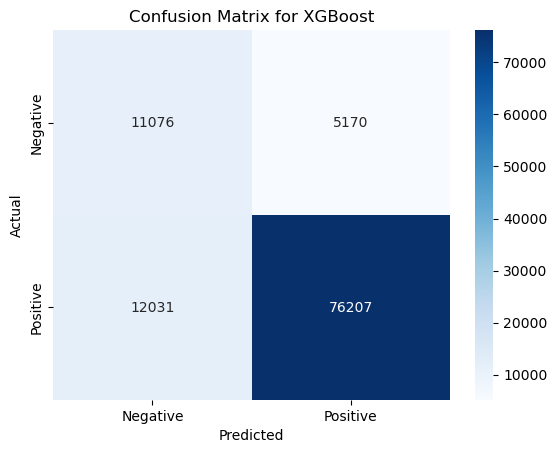

In [12]:
# XG-Boost: 50 trees

# Model
xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="mlogloss",
    scikit_learn=True,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_tfidf_binary)

# Classification report
print("XGBoost Results:")
print(classification_report(y_test_binary, y_pred_xgb, target_names=['Negative', 'Positive']))

# Confusion matrix
cm_xgb = confusion_matrix(y_test_binary, y_pred_xgb)

# Plot confusion matrix heatmap
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# This code did not work
# XGBoost with Grid Search

# Create a pipeline to ensure compatibility with GridSearchCV
xgb_pipeline = make_pipeline(
    XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )
)

# Define the parameter grid
param_grid = {
    'xgbclassifier__n_estimators': [100, 150],
    'xgbclassifier__max_depth': [4, 6],
    'xgbclassifier__learning_rate': [0.1, 0.3],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf_resampled_binary, y_train_resampled_binary)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best f1_weighted score: ", grid_search.best_score_)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Predict on the test set
y_pred_best_xgb = best_xgb.predict(X_test_tfidf_binary)

# Classification report
print("XGBoost Results after GridSearch:")
print(classification_report(y_test_binary, y_pred_best_xgb, target_names=['Negative', 'Positive']))

# Confusion matrix
cm_best_xgb = confusion_matrix(y_test_binary, y_pred_best_xgb)

# Plot confusion matrix heatmap
sns.heatmap(cm_best_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Best XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Using SMOTE-ENN

In [2]:
# Libraries

# Standard libraries

import numpy as np
import pandas as pd
import kagglehub
import os
pd.set_option('display.max_colwidth', None)  # Show full content of columns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Visualization libraries 

import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter

# Feature extraction (vectorization)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Stemming and Lemmatization
from nltk.stem.snowball import PorterStemmer
from nltk.stem import WordNetLemmatizer # This one was preferred over PorterStemmer

# Train-test split
from sklearn.model_selection import train_test_split

# Machine learning models

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import imblearn
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE # Addressing class imbalances by increasing minority classes size
from imblearn.under_sampling import RandomUnderSampler # Addressing class imbalances by decreasing majority classes size
from imblearn.combine import SMOTEENN

from collections import Counter

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

# Saving

import joblib

In [4]:
# Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")
df = df.reset_index(drop=True)
# Step 1: Remove the Neutral Class
df_binary = df[df['Sentiment'] != 'Neutral']  # Remove rows where Sentiment is 'Neutral'
# Verify the new class distribution
print(df_binary['Sentiment'].value_counts())

Sentiment
Positive    441190
Negative     81230
Name: count, dtype: int64


In [6]:
# Step 2: Redefine Features (X) and Target (y)
X_binary = df_binary['cleaned_text']  # Features
y_binary = df_binary['Sentiment']     # Target

# Step 3: Perform Stratified Split
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

# Replace NaN values with an empty string
X_train_binary = X_train_binary.fillna("")
X_test_binary = X_test_binary.fillna("")

# Step 4: TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))  # Use unigrams and bigrams
X_train_tfidf_binary = tfidf.fit_transform(X_train_binary)
X_test_tfidf_binary = tfidf.transform(X_test_binary)

In [ ]:
# Step 5: Apply SMOTE-ENN on the training data
# SMOTE-ENN will oversample the minority class and clean the dataset using ENN
smote_enn = SMOTEENN(random_state=42) 

# Apply SMOTE-ENN to the TF-IDF transformed training data
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_tfidf_binary, y_train_binary)

# Verify the new class distribution after resampling
print("Class distribution after SMOTE-ENN:", Counter(y_train_resampled))

# 331 mins, I had to interrupt the process

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEsti

KeyboardInterrupt: 